Statlog (Heart) Data Set


W zbiorze danych można znaleźć następujące informacje, które posłużą do przewidzenia czy u osoby o danym zestawie atrybutów występuje choroba serca czy nie.

Atrybuty:

- wiek
- płeć
- typ bólu w klatce piersiowej (4 wartości)
- ciśnienie krwi w spoczynku
- cholesterol w surowicy krwi [mg/dl]
- cukier w krwi naczczo > 120 [mg/dl]
- wynik elektrokardiograficzny w spoczynku (wartości 0,1,2)
- osiągnięta maksymalna częstość akcji serca
- dławica piersiowa indukowana wysiłkiem
- oldpeak = obniżenie odcinka ST wywołane wysiłkiem fizycznym w stosunku do spoczynku
- szczytowe nachylenie odcinka ST w czasie wysiłku fizycznego
- liczba głównych naczyń (0-3) pokolorowanych przez fluoroskopię
- hemoglobina(poziom) thal: 3 = normalny; 6 = utrwalony ubytek; 7 = odwracalny ubytek

Dysponuje:

- 270 rekordami
- 2 klasy danych (choroba lub jej brak)
- 13 atrybutów
- z klasy brak choroby mamy 150 przypadków, a klasy choroba 120

# Sieć FFNN

-----------------

## Przygotowywanie danych

### Importowanie

Poniżej zainportowano niezbędne w dalszej pracy biblioteki. Oraz wczytano zbiór danych w formie DataFrame. Nastepnie wypisano zbiór danych oraz sprawdzono, czy nie ma brakujących wartości. Z otrzymanych danych wynika, że zbiór jest pełny. 


In [2]:

import pandas as pd #załadowanie danych i ich obróbka  
import seaborn as sns #wizualizacja 
import matplotlib.pyplot as plt #wizualizacja
import numpy as np # algebra
from sklearn.preprocessing import normalize # ML algorytmy 
from sklearn.metrics import roc_curve, roc_auc_score, classification_report # Krzywa roc, auc, raport o klasyfikacji


df = pd.read_csv('heart.data', delimiter = ' ' ,index_col=False)
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        270 non-null    float64
 1   sex                                        270 non-null    float64
 2   chest_pain_type                            270 non-null    float64
 3   resting_blood_pressure                     270 non-null    float64
 4   serum_cholestoral_in_mg/dl                 270 non-null    float64
 5   fasting_blood_sugar_>_120_mg/dl            270 non-null    float64
 6   resting_electrocardiographic_results       270 non-null    float64
 7   maximum_heart_rate_achieved                270 non-null    float64
 8   exercise_induced_angina                    270 non-null    float64
 9   oldpeak                                    270 non-null    float64
 10  the_slope_of_the_peak_exer

### Wizualizacja wybranych atrybutów zbioru

Poniżej znajduje się wykres heatmap, który pokazuje korelacje pomiędzy istniejącymi kolumnami. Im jaśniejszy kolor tym bardziej są skorelowane ze sobą dane atrybuty. 

<AxesSubplot:>

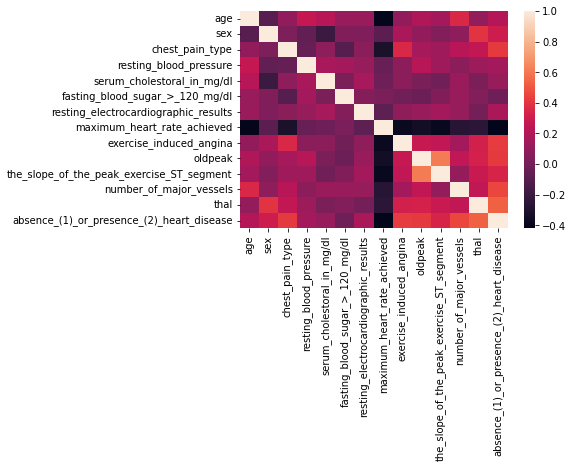

In [3]:

sns.heatmap(df.corr())


### Przygotowanie wektora wejściowego i wyjściowego dla sieci

Najpierw wybrano odpowiednie kolumny ze zbioru danych, tak aby otrzymać dane wejściowe i wyjściowe.

Następnie zamieniono kolumne z wiekiem na kategorie, ponieważ po zakodowaniu wartości z niej na właściwej liczbie bitów można je podać sieci tak aby zostały adekwatnie zinterpretowane.

Dalej wszystkie dane kategoryczne zostały zakodowane na odpowiedniej liczbie bitów.

Ostatecznie zbiór danych został przeskalowany do wartości z zakresu od 0 do 1, ponieważ algorytm działający podczas treningu sieci taki jak, gradient descent, lepiej sobie radzi z danymi które są w podobnej skali.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Wybranie odpowiednich kolumn
X = df.iloc[:,:-1]
y = df.iloc[:,-1].values

# Zamiana kolumny wiek na klasy
# 21-40 lat -> 0
# 41-60 lat -> 1
# 61-90 lat -> 2

bins = [20,40,60,90]
labels = [0,1,2]
X['age'] = pd.cut(X.age,bins,labels=labels)

# Zakodowanie danych kategoryczny
X = pd.get_dummies(data=X, columns=["age","sex", "chest_pain_type", "fasting_blood_sugar_>_120_mg/dl", "resting_electrocardiographic_results", "exercise_induced_angina", "the_slope_of_the_peak_exercise_ST_segment", "number_of_major_vessels", "thal"])

# Skalowanie danych
data = X.select_dtypes(np.number)
X[data.columns] = MinMaxScaler().fit_transform(data)
X


,resting_blood_pressure,serum_cholestoral_in_mg/dl,maximum_heart_rate_achieved,oldpeak,age_0,age_1,age_2,sex_0.0,sex_1.0,chest_pain_type_1.0,...,the_slope_of_the_peak_exercise_ST_segment_1.0,the_slope_of_the_peak_exercise_ST_segment_2.0,the_slope_of_the_peak_exercise_ST_segment_3.0,number_of_major_vessels_0.0,number_of_major_vessels_1.0,number_of_major_vessels_2.0,number_of_major_vessels_3.0,thal_3.0,thal_6.0,thal_7.0
0,0.339623,0.447489,0.290076,0.387097,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.198113,1.000000,0.679389,0.258065,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.283019,0.308219,0.534351,0.048387,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.320755,0.312785,0.259542,0.032258,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.245283,0.326484,0.381679,0.032258,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.735849,0.166667,0.694656,0.080645,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
266,0.245283,0.312785,0.778626,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
267,0.433962,0.383562,0.625954,0.209677,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
268,0.433962,0.150685,0.587786,0.064516,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Podział zbioru na zbiór treningowy, testowy i walidacyjny.


Poniżej dokonano podziału danych na zbiór treningowy, testowy oraz walidacyjny. Zbiór treningowy to 60% danych, pozostałe 40% to zbiór tymczasowy, który zostanie podzielony po równo na zbiór testowy i walidacyjny.
Dzięki random_state podział będzie zawsze taki sam, czyli zawsze te same próbki danych będą w poszczególnych zbiorach.

Następnie dla każdej z klas (1 lub 2) tworzę ich reprezentacje jako wektory, które będą podawane jako wynik sieci neuronowej.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from keras.utils import np_utils

# Podział zbioru na podzbiory
X_train, X_temp, y_train, y_temp = train_test_split(X,y,train_size=0.60,random_state=1)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp,y_temp,train_size=0.50,random_state=1)

# Zamiana klas całkowitych na klasy w formacie binarnym
y_train=np_utils.to_categorical(y_train-1,num_classes=2)
y_test=np_utils.to_categorical(y_test-1,num_classes=2)
y_valid=np_utils.to_categorical(y_valid-1,num_classes=2)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)


"""
[1] -> [0] -> [1 0] # Osoba zdrowa
[2] -> [1] -> [0 1] # Osoba chora
"""

(162, 30)
(54, 30)
(54, 30)
(162, 2)
(54, 2)
(54, 2)


'\n[1] -> [0] -> [1 0] # Osoba zdrowa\n[2] -> [1] -> [0 1] # Osoba chora\n'

## Struktura sieci - Model 0



### Budowanie sieci neuronowej



Struktura sieci:

*   Warstwa wejściowa:
    - 30 neuronów, ponieważ tyle mam elementów w wektorze wejściowym
*   I warstwa ukryta:
    - 61 neuronów - ich liczba została wybrana według wzoru 2n+1, gdzie n to liczba wejść
    - funkcja aktywacji to relu, ponieważ jest wybierana domyślnie oraz zakres wartości jaki przyjmuje odpowiada oczekiwaniom 

*   Warstwa wyjściowa:
    - 2 neurony, ponieważ mam dwie klasy wyników, które można zakodować używając 2 wyjść
    - funkcja aktywacji to sigmoid, ponieważ oczekuje wartości z przedziału (0,1) co pozwoli mi później przekonwertować to na wektory binarne


Po zbudowaniu sieci dodaje ochronę przed przetrenowaniem sieci, która polega na na wyłączeniu w trakcie treningu określonej ilości neuronów danej warstwy np 20%.

Następnie kompiluje uzyskany model z funkcją straty binary_crossentropy, ponieważ jest ona odpowiednia do problemów klasyfikacji binarnej, czyli takiego jaki rozwiązuje. Mój problem posiada 2 klasy wyników, czyli odpowiadam na pytanie czy ktoś ma chorobe serca, czy nie.

Jako parametr optimizer, czyli rodzaj algorytmu aktualizującego wagi wybieram 'adam' (algorytm gradient descent), ponieważ jest szybko zbieżny, więc nie potrzebuje dużo czasu żeby osiągnąć minimum lub maksimum.

Parametr metrice ustawiam na 'accuracy', żeby dowiedzieć się jak dobrze przygotowany jest mój model.


In [6]:
import keras
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 

# Inicjalizacja modelu
model = Sequential()

# Dodawanie warstw
model.add(Dense(61,input_dim=30, activation='relu')) # definiuje mi jednocześnie rozmiar pierwszej warstwy wejściowej i pierwszej ukrytej
 
# Ochrona przed przetrenowaniem
model.add(Dropout(0.2))

# Warstwa wyjściowa
model.add(Dense(2,activation='sigmoid'))

# Kompilacja sieci neuronowej
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])


## Uczenie sieci





### Trenowanie sieci neuronowej


Poniżej trenuje uzyskany wczesniej model na danych treningowych. Uzyskany wcześniej zbiór z danymi walidacyjnymi posłuży do oceny uzyskanych wyników po każdej epoce. 

Liczba epok na początek zostaje ustawiona na 100, a liczba wierszy po których nastąpi aktualizacja wag to 32. Nie ma jednoznacznej reguły na wybór odpowiedniej liczby tych wartości, więc zaczynam od takich parametrów i obserwuje jak będzie się zachowywać błąd oraz dokładność w zbiorze treningowym i walidacyjnyym.

Parametr verbose = 1 pozwala obserwować błąd oraz dokładność obu zbiorów w każdej epoce. 

Celem jest wybranie konfiguracji modelu, która zapewnij najniższe straty i najwyższą możliwą dokładność dla danego zbioru danych.

In [7]:
# Dopasowywanie sieci neuronowej do zbioru treningowego

history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid), batch_size=32,epochs=100,verbose=1)


Epoch 1/100
6/6 [==============================] - 5s 252ms/step - loss: 0.7601 - accuracy: 0.3827 - val_loss: 0.7052 - val_accuracy: 0.5556
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 0.7166 - accuracy: 0.4630 - val_loss: 0.6744 - val_accuracy: 0.6852
Epoch 3/100
6/6 [==============================] - 0s 30ms/step - loss: 0.6945 - accuracy: 0.5309 - val_loss: 0.6481 - val_accuracy: 0.7963
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6574 - accuracy: 0.6605 - val_loss: 0.6262 - val_accuracy: 0.7963
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6299 - accuracy: 0.7531 - val_loss: 0.6063 - val_accuracy: 0.8148
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6072 - accuracy: 0.7840 - val_loss: 0.5887 - val_accuracy: 0.8148
Epoch 7/100
6/6 [==============================] - 0s 17ms/step - loss: 0.5760 - accuracy: 0.8519 - val_loss: 0.5730 - val_accuracy: 0.8148
Epoch 8/100
6/6 [==

## Wyniki jakie daje sieć



Powyżej widać, że zarówno w zbiorze treningowym jak i walidacyjnym rozmiar błędu maleje wraz ze zwiększaniem się numeru epoki, a precyzja przewidywania rośnie.

### Dokładność i precyzja

Poniżej obliczono dokładność i precyzje wyników jakie daje sieć używając do tego zbioru testowego.

Najpierw sieć wygenerowała przewidywany wynik dla zbioru testowego w postaci wektorów. Następnie przewidywany wynik i wynik jaki powinien być zostały zamienione na wektory jednowymiarowe stworzone z 0 i 1. W kolejnym kroku używamy funkcji calssification_report do oceny sieci.



In [8]:
# zbiór testowy
prediction=model.predict(X_test) 

# ta funkcja szuka maksymalnych wartości po kolumnach; jak znajdzie to wstawia indeks tej kolumny, tak dostaje tablice 0 i 1
y_label=np.argmax(y_test,axis=1) 
predict_label=np.argmax(prediction,axis=1)
target_names=["absence of disease (0)", "presence of disease (1)"]

# Dokładność i precyzja
print(classification_report(y_label,predict_label,target_names=target_names))



2/2 [==============================] - 0s 5ms/step
                         precision    recall  f1-score   support

 absence of disease (0)       0.80      0.86      0.83        28
presence of disease (1)       0.83      0.77      0.80        26

               accuracy                           0.81        54
              macro avg       0.82      0.81      0.81        54
           weighted avg       0.82      0.81      0.81        54



Wyświetlam raport z klasyfikacji, który mierzy jakość przewidywań sieci.
- Precision - procent poprawnych pozytywnych przewidywań w stosunku do całkowitej liczby pozytywnych przewidywań modelu
- Recall - procent poprawnych pozytywnych przewidywań w stosunku do całkowitej liczby rzeczywistych pozytywnych przewidywań modelu
- F1-Score - średnia ważona harmoniczna precyzji i recall; im bliżej 1, tym lepszy model
- Support - ilość próbek należących do danej klasy

Dokładność: Na poziomie bliskim 80%

Precyzja: Wysoka dla przypadku gdy ktoś jest chory, nieznacznie niższa w przypadku klasyfikowania, że ktoś jest zdrowy.

### Krzywa ROC

Krzywa ROC to jeden ze sposobów wizualizacji jakości klasyfikacji, pokazujący zależności wskaźników TPR (True Positive Rate) oraz FPR (False Positive Rate).

Im bardziej wykres zmierza do lewego górnego rogu tym lepszy klasyfikator otrzymaliśmy. Oznacza to, że otrzymujemy więcej wyników pozytywnie prawdziwych w stosunku do fałszywie pozytywnych, które są bardzo niepożądane, ponieważ w tym przypadku wskzują, że ktoś jest zdrowy gdy tak naprawdę jest chory. 

Dodatkowo pole pod krzywą (AUC) może służyć jako podsumowanie umiejętności modelu.


AUC:  0.8956043956043955


Text(0, 0.5, 'True Positive Rate')

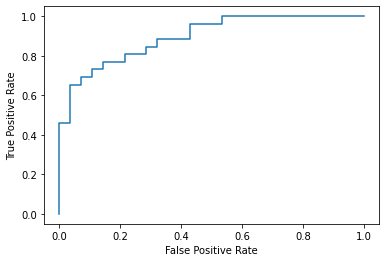

In [9]:
# Krzywa ROC
y_proba = prediction[:,1]
fpr, tpr, threshold = roc_curve(y_label,y_proba)

# Pole powierzchni pod wykresem (AUC)
auc = roc_auc_score(y_label,y_proba)
print('AUC: ', auc)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Widać, że w przypadku tego modelu krzywa ROC jest w miarę blisko lewego górnego rogu, co oznacza, że klasyfikacja przebiega całkiem sprawnie. Pole pod krzywą to około 0.80-0.90, potwierdza wysoką skuteczność klasyfikatora. 

### Złożoność i zbieżność


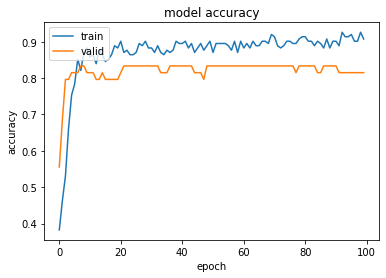

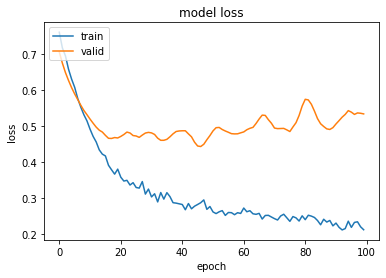

In [10]:
# Podsumowanie historii dokładności
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# Podsumowanie historii błędu
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Zbieżność: Po około 20 epokach dokładność sieci zaczyna oscylować w okolicach 80%. Jednak z drugiego wykresu widać, że błąd dla zbioru walidacyjnego po spadku zaczyna znowu rosnąć co świadczy o przetrenowaniu modelu. 

Złożoność: Mało złożona sieć 

Tylko jedna warstwa ukryta z 61 neuronami, które używają funkcji relu. Jej obliczenie nie jest skomplikowana, ponieważ to max(0,x). Wyjście to 2 neurony które używają bardziej skomplikowanej fukcji niż relu, bo funkcji sigmoid, ale to tylko 2 neurony, więc całościowo nie komplikuje to bardzo budowy sieci. Aktualizacja wag występuje co 32 próbki danych w trakcie trwania każdej ze 100 epok.

## Dostrajanie parametrów

Poniżej zostało przygotowanych kilka wersji modeli w celu dobrania jak najlepszych parametrów sieci, która da nam najlepsze możliwe przewidywanie wyniku dla naszych danych.

### Model 1

Zmieniono liczbę epok z 100 na 20, aby zmniejszyć ryzyko przetrenowania, które występuje w modelu 0.

Epoch 1/20
6/6 [==============================] - 1s 64ms/step - loss: 0.7156 - accuracy: 0.4444 - val_loss: 0.6789 - val_accuracy: 0.5370
Epoch 2/20
6/6 [==============================] - 0s 10ms/step - loss: 0.6779 - accuracy: 0.5556 - val_loss: 0.6560 - val_accuracy: 0.6111
Epoch 3/20
6/6 [==============================] - 0s 15ms/step - loss: 0.6430 - accuracy: 0.6728 - val_loss: 0.6379 - val_accuracy: 0.7593
Epoch 4/20
6/6 [==============================] - 0s 17ms/step - loss: 0.6268 - accuracy: 0.7654 - val_loss: 0.6204 - val_accuracy: 0.8148
Epoch 5/20
6/6 [==============================] - 0s 16ms/step - loss: 0.5982 - accuracy: 0.7901 - val_loss: 0.6047 - val_accuracy: 0.8333
Epoch 6/20
6/6 [==============================] - 0s 15ms/step - loss: 0.5818 - accuracy: 0.8210 - val_loss: 0.5891 - val_accuracy: 0.8148
Epoch 7/20
6/6 [==============================] - 0s 17ms/step - loss: 0.5580 - accuracy: 0.8395 - val_loss: 0.5733 - val_accuracy: 0.8333
Epoch 8/20
6/6 [===========

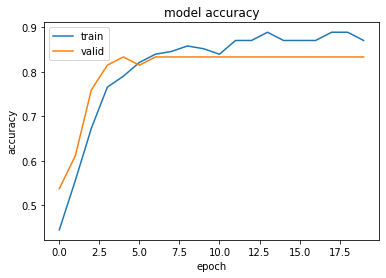

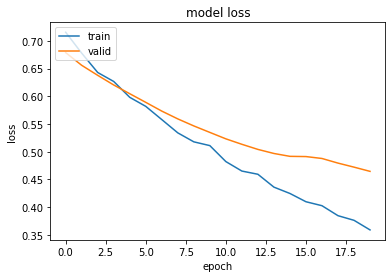

In [11]:
# Inicjalizacja modelu
model5 = Sequential()

# Dodawanie warstw
model5.add(Dense(61,input_dim=30, activation='relu'))
# Ochrona przed przetrenowaniem
model5.add(Dropout(0.2))
model5.add(Dense(2,activation='sigmoid')) 

# Kompilacja sieci neuronowej
model5.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Trenowanie sieci neuronowej
history5 = model5.fit(X_train,y_train,validation_data=(X_valid,y_valid), batch_size=32,epochs=20,verbose=1)

# Testowanie sieci
prediction5=model5.predict(X_test)
y_label5=np.argmax(y_test,axis=1) 
predict_label5=np.argmax(prediction5,axis=1)

# Dokładność i precyzja
target_names=["absence of disease (0)", "presence of disease (1)"]
print(classification_report(y_label5,predict_label5, target_names=target_names))

# Podsumowanie historii dokładności
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# Podsumowanie historii błędu
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Dokładność: Nie uległa znaczącej zmianie w stosunku do modelu 0.

Precyzja: Praktycznie bez zmian dla obu klas w porównaniu do modelu 0.

Zbieżność: Maksymalna dokładność została osiągnięta, ponieważ według wykresu utrzymuje się na stałym poziomie około 80%. Minimalny błąd prawdopodobnie nie został osiągnięty, ponieważ obje krzywe nadal zbiegają do mniejszych wartości w okolicach ostatnich epok.

Złożoność: Mniejsza niż model 0

Model zostanie przetrenowny na danych znacznie mniej razy niż w modelu 0, przez co wykona się znacznie mniej obliczeń.
 

AUC:  0.8873626373626373


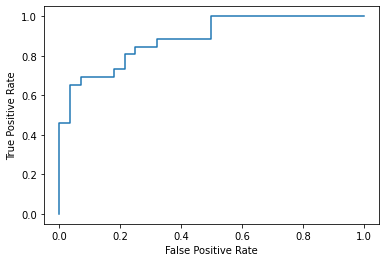

In [12]:
# Krzywa ROC
y_proba5 = prediction5[:,1]
fpr5, tpr5, _ = roc_curve(y_label5,y_proba5)
plt.plot(fpr5,tpr5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Pole powierzchni pod krzywą (AUC)
auc5 = roc_auc_score(y_label5,y_proba5)
print('AUC: ', auc5)


Wykres jest blisko lewego górnego narożnika, czyli otrzymujemy stosunkowo więcej wyników pozytywnie prawdziwych niż fałszywie prawdziwych. Z tego wynika, że model jest dobrym klasyfikatorem. 


### Model 2

Sprawdzam czy zmniejszenie liczby neuronów w warstwie ukrytej o połowe poprawi działanie sieci. 

Epoch 1/100
6/6 [==============================] - 1s 62ms/step - loss: 0.8168 - accuracy: 0.4506 - val_loss: 0.7549 - val_accuracy: 0.4630
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7355 - accuracy: 0.5247 - val_loss: 0.7194 - val_accuracy: 0.4444
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 0.7163 - accuracy: 0.5432 - val_loss: 0.6915 - val_accuracy: 0.5926
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6884 - accuracy: 0.6296 - val_loss: 0.6696 - val_accuracy: 0.7037
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6489 - accuracy: 0.6975 - val_loss: 0.6524 - val_accuracy: 0.7778
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6182 - accuracy: 0.7160 - val_loss: 0.6377 - val_accuracy: 0.7407
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5936 - accuracy: 0.7593 - val_loss: 0.6253 - val_accuracy: 0.7407
Epoch 8/100
6/6 [======

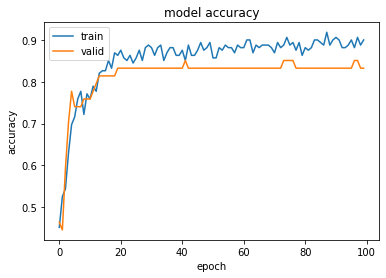

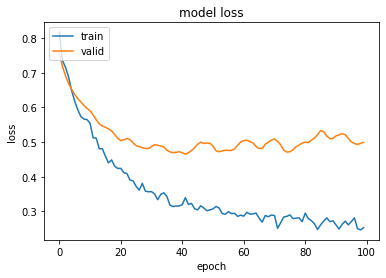

In [13]:
# Inicjalizacja modelu
model2 = Sequential()

# Dodawanie warstw
model2.add(Dense(30,input_dim=30, activation='relu'))
# Ochrona przed przetrenowaniem
model2.add(Dropout(0.2))
model2.add(Dense(2,activation='sigmoid')) 


# Kompilacja sieci neuronowej
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Trenowanie sieci neuronowej
history2 = model2.fit(X_train,y_train,validation_data=(X_valid,y_valid), batch_size=32,epochs=100,verbose=1)

# Testowanie sieci 
prediction2=model2.predict(X_test)
y_label2=np.argmax(y_test,axis=1)
predict_label2=np.argmax(prediction2,axis=1)

# Dokładność i precyzja
target_names=["absence of disease (0)", "presence of disease (1)"]
print(classification_report(y_label2,predict_label2, target_names=target_names))

# Podsumowanie historii dokładności
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# Podsumowanie historii błędu
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Dokładność: Podobna jak w modelu 0.

Precyzja: Podobna jak w modelu 0.

Zbieżność: Dokładność modelu bardzo szybko zbiega do około 80% i po około 30 epoce utrzymuje się na tym samym poziomie. Błąd maleje, ale tak jak w przypadku modelu 0 zdaża się, że błąd zbioru walidacyjnego zaczyna rosnąć co oznacza przeuczenie. Sieć ma prawdopodobnie nadal niewłaściwą liczbę neuronów.

Złożoność: Znacznie mniejsza złożoność niż w modelu 0.

Warstwa ukryta zawiera teraz 30 neuronów z funkcją relu co wymaga wykonania znacznie mniej obliczeń niż we wcześniejszych modelach.



AUC:  0.896978021978022


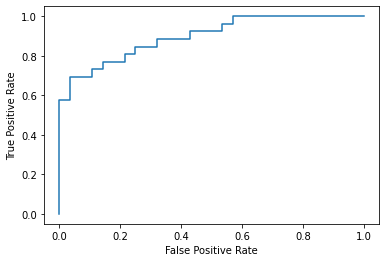

In [14]:
# Krzywa ROC
y_proba2 = prediction2[:,1]
fpr2, tpr2, _ = roc_curve(y_label2,y_proba2)
plt.plot(fpr2,tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Pole powierzchni pod wykresem
auc2 = roc_auc_score(y_label2,y_proba2)
print('AUC: ', auc2)


Wykres jest blisko lewego górnego narożnika, czyli otrzymujemy stosunkowo więcej wyników pozytywnie prawdziwych niż fałszywie prawdziwych. Z tego wynika, że model jest dobrym klasyfikatorem pod warunkiem, że nie przetrenuje się. 


### Model 3

Zmiana funkcji aktywacji w warstwie wyjściowej na tanh, który jest odpowiedni do problemów klasyfikacji.

Epoch 1/100
6/6 [==============================] - 1s 64ms/step - loss: 3.8761 - accuracy: 0.5988 - val_loss: 3.9243 - val_accuracy: 0.5185
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 3.3921 - accuracy: 0.5926 - val_loss: 3.7783 - val_accuracy: 0.5185
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 3.3564 - accuracy: 0.5926 - val_loss: 3.5434 - val_accuracy: 0.5185
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 3.1535 - accuracy: 0.5988 - val_loss: 3.3971 - val_accuracy: 0.5370
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 2.8695 - accuracy: 0.6049 - val_loss: 3.0029 - val_accuracy: 0.5556
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 2.6154 - accuracy: 0.6235 - val_loss: 2.4912 - val_accuracy: 0.5741
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 2.2307 - accuracy: 0.6543 - val_loss: 2.1659 - val_accuracy: 0.6111
Epoch 8/100
6/6 [====

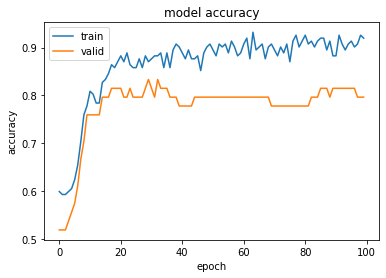

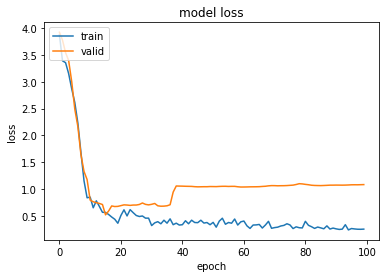

In [15]:
# Inicjalizacja modelu
model3 = Sequential()

# Adding layers
model3.add(Dense(61,input_dim=30, activation='relu')) # definiuje mi jednocześnie rozmiar pierwszej warstwy wejściowej i pierwszej ukrytej
# Ochrona przed przetrenowaniem
model3.add(Dropout(0.2))
model3.add(Dense(2,activation='tanh')) 


# Kompilacja sieci neuronowej
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# Trenowanie sieci neuronowej
history3 = model3.fit(X_train,y_train,validation_data=(X_valid,y_valid), batch_size=32,epochs=100,verbose=1)

# Testowanie sieci
prediction3=model3.predict(X_test)
y_label3=np.argmax(y_test,axis=1)
predict_label3=np.argmax(prediction3,axis=1)

# Dokładność i precyzja
target_names=["absence of disease (0)", "presence of disease (1)"]
print(classification_report(y_label3,predict_label3, target_names=target_names))

# Podsumowanie historii dokładności
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# Podsumowanie historii błędu
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



Dokładność: Jest porównywalna jak w modelu 0.

Precyzja: Zbliżona jak model 0.

Zbieżność: Dokładność oscyluje w okolicach 80% po około 40 epokach. Błąd bardzo szybko spada, aby następnie wzrosnąć co również może być wynikiem przetrenowania.  

Złożoność: Budowa podobna jak model 0. 

Jedyna zmiana w stosunku do modelu 0 to funkcja aktywacji w warstwie wyjściowej ustawiona na tanh, która nie jest skomplikowana do obliczenia.

AUC:  0.8928571428571429


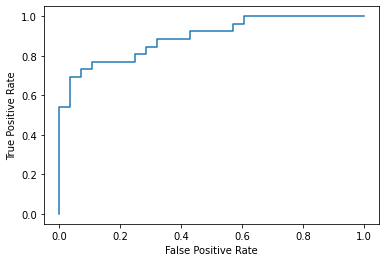

In [16]:
# Krzywa ROC
y_proba3 = prediction3[:,1]
fpr3, tpr3, _ = roc_curve(y_label3,y_proba3)
plt.plot(fpr3,tpr3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Pole powierzchni pod krzywą
auc3 = roc_auc_score(y_label3,y_proba3)
print('AUC: ', auc3)



Wykres jest blisko lewego górnego narożnika, czyli otrzymujemy stosunkowo więcej wyników pozytywnie prawdziwych niż fałszywie prawdziwych. Z tego wynika, że model jest dobrym klasyfikatorem pod warunkiem, że nie przetrenuje się. 


## Podsumowanie


Wyniki dla wszystkich modeli są bardzo zmienne, jednak widać pewną powtarzalność w wynikach dla poszczególnych modeli. Model 0, 1, 2 i 3 osiągają dość często wysoką dokładność wyników oraz precyzje dla poszczególnych klas. Jednocześnie przy zadanej liczbie epok osiągają zbieżność szybciej lub wolniej. Z modeli powyżej można stwierdzić, że najlepszy jest model 1 ponieważ jako jedyny nie miał problemu z przetrenowaniem.
